In [51]:
from pathlib import Path, WindowsPath, PosixPath
# SETTINGS ------------------------------------------------------------------------
CONFIG = {
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_final"), 
}
for key in CONFIG: globals()[key] = CONFIG[key];

In [52]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
# ----------------------------------------------------------------------------------------
import sys, os
if 'ROOT' not in globals(): global ROOT; ROOT = Path('../..').resolve()
print(f"{'-'*60}\nDirectories:\n  {ROOT}:\t\t\t{', '.join([_.name for _ in ROOT.glob('*/')])}")
sys.path.append(os.path.abspath(ROOT))
from data import get_data_path  # paths set in "data/__init__.py"
global DATA_PATH
DATA_PATH = get_data_path()
print(f"  {DATA_PATH}:\t\t\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}")

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
from src.utils.data_utils import *
from src.utils.Trainer import *
from VehModel import CreateVehicle
from Mot_Pwr import estimate_mot_pwr

# NOTEBOOK / SCRIPT SETTINGS -------------------------------------------------------------
# ----------------------------------------------------------------------------------------
global IS_NOTEBOOK
IS_NOTEBOOK = False
try:    # if running in IPython
    shell = get_ipython().__class__.__name__ # type: ignore 
    from IPython.display import display, HTML, Javascript, clear_output
    from IPython.core.magic import register_cell_magic
    @register_cell_magic    # cells can be skipped by using '%%skip' in the first line
    def skip(line, cell): return
    from tqdm.notebook import tqdm as tqdm_nb
    IS_NOTEBOOK = True
    print(f"{'-'*60}\nRunning in notebook mode")
except (NameError, ImportError):    # if running in script
    from tqdm import tqdm as tqdm
    from tabulate import tabulate
    print(f"{'-'*60}\nRunning in script mode")
    
# GENERAL MODULE IMPORTS -----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
import math, time, random, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import pyarrow.parquet as pq
from copy import deepcopy
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
from scipy.signal import savgol_filter

------------------------------------------------------------
Directories:
  /home/sieglew/MA-eR-PINN:			project, ref, test, data, src, .git, archive
  /home/sieglew/MA-Data:			__pycache__, trips_processed_resampled, final, y_true, processed, TripSequences, trips_processed_pickles, final_2, trips_processed_final
------------------------------------------------------------
Running in notebook mode


In [53]:
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pickle_folder = Path(DATA_PATH, "TripSequences", "trips_processed_pickles") # Processed trip files

all_files = [Path(input_folder, f).name for f in os.listdir(input_folder) if f.endswith(".parquet")]
print(f"{'-'*60}\nTotal Files:\t{len(all_files)}")

------------------------------------------------------------
Total Files:	18629


In [54]:
samples = random.sample(all_files,10)

0
V4_T630
1
V17_T668
2
V17_T5190
3
V17_T4213
4
V15_T813
5
V17_T3599
6
V17_T1954
7
V17_T2152
8
V12_T137
9
V18_T513


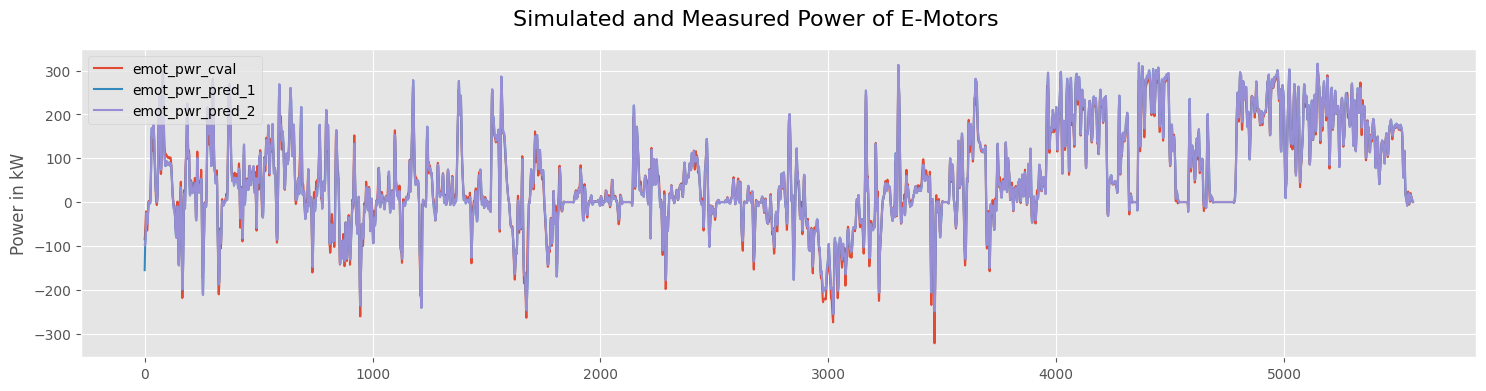

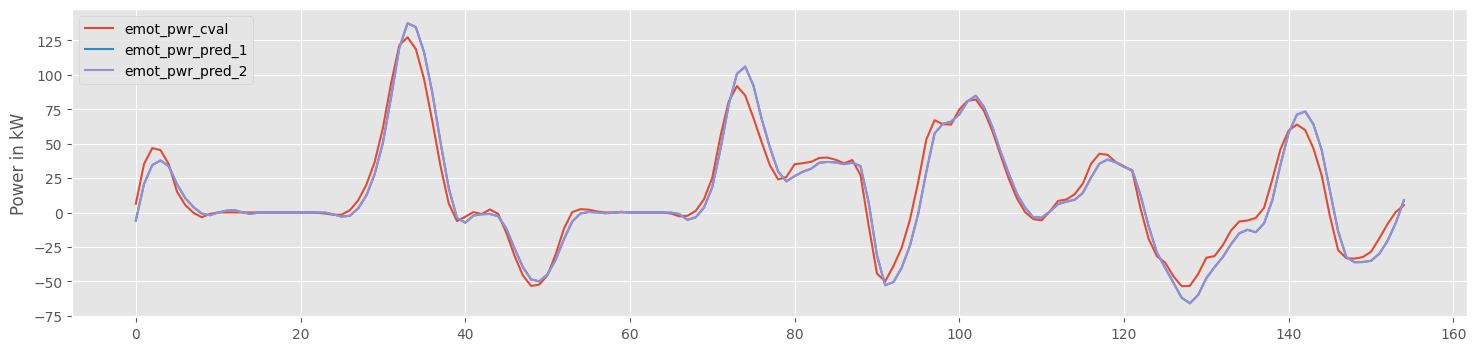

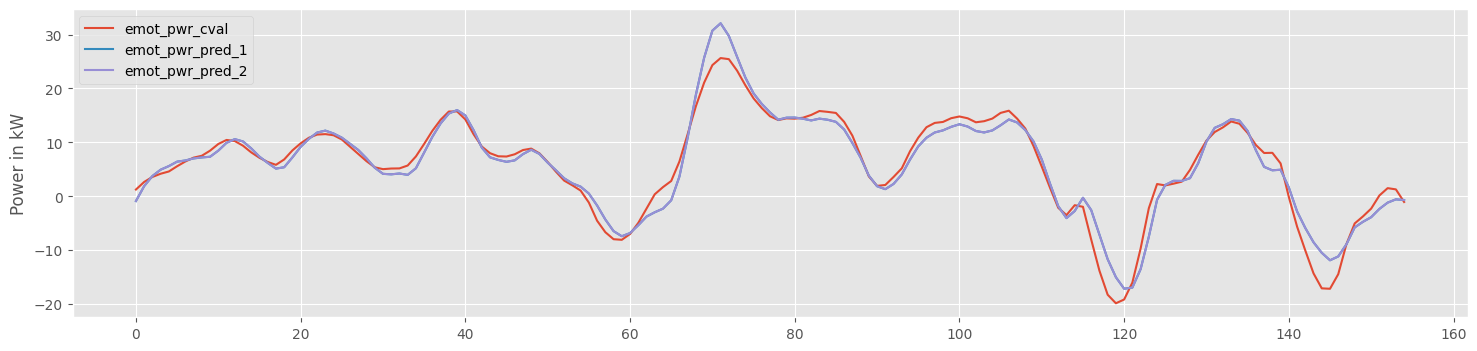

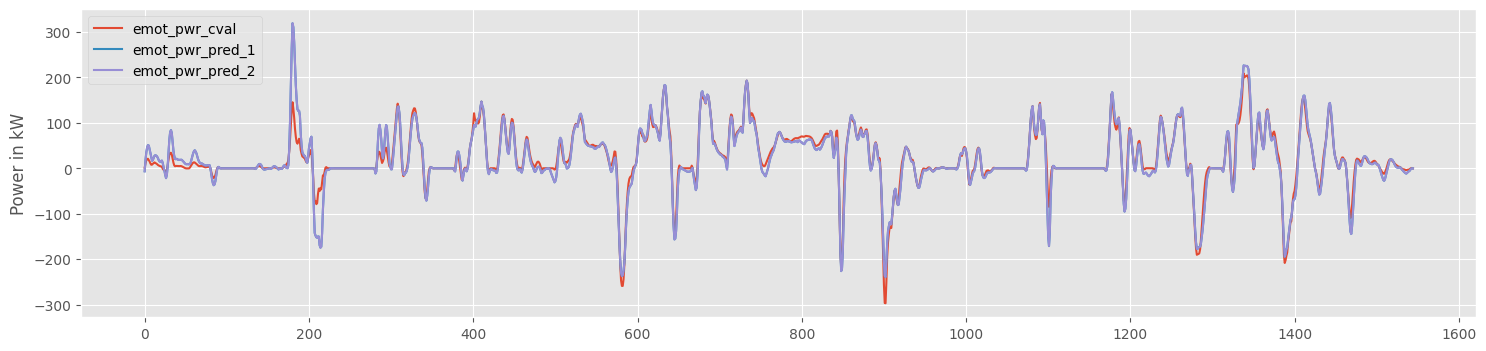

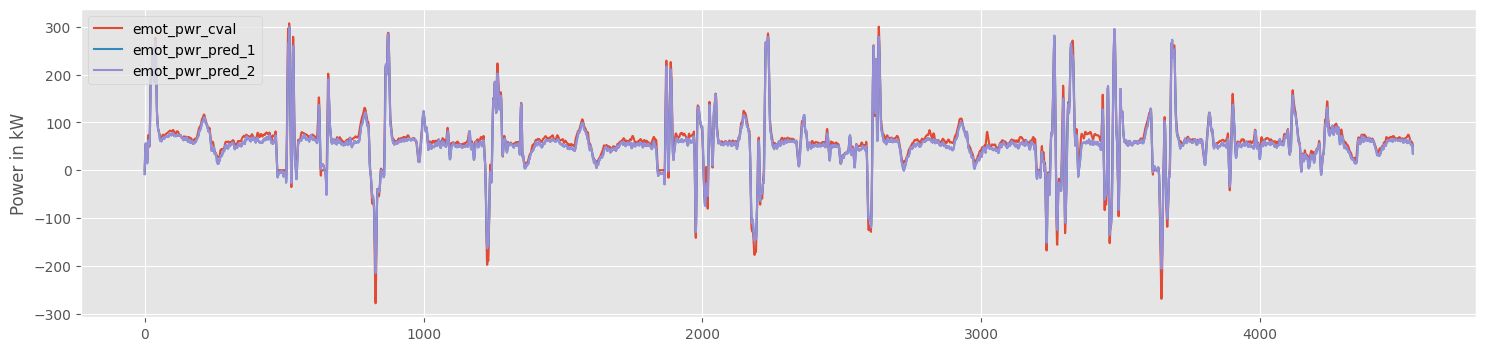

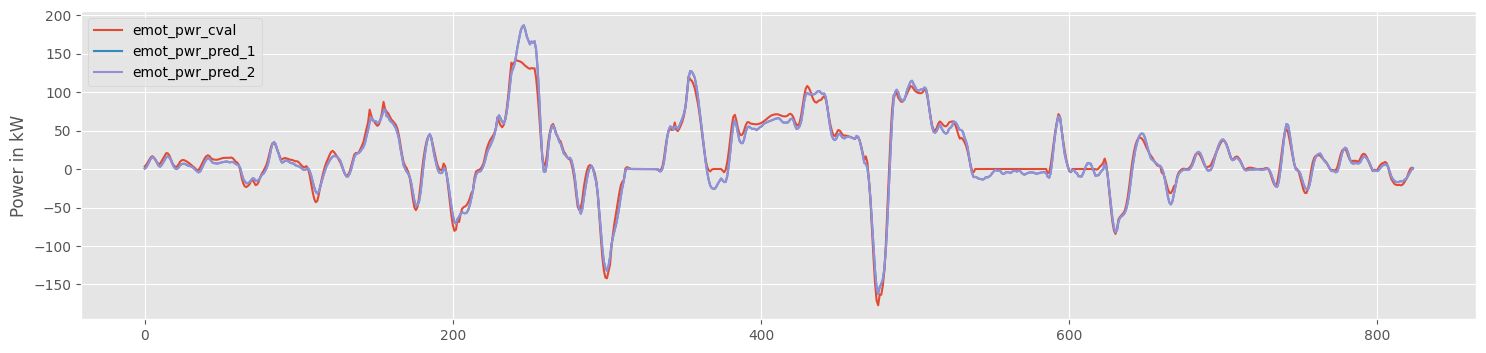

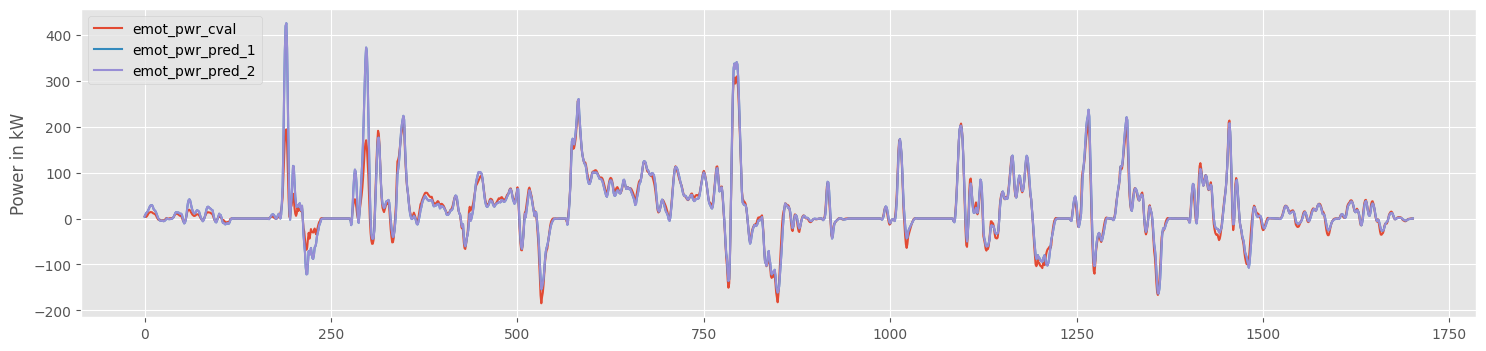

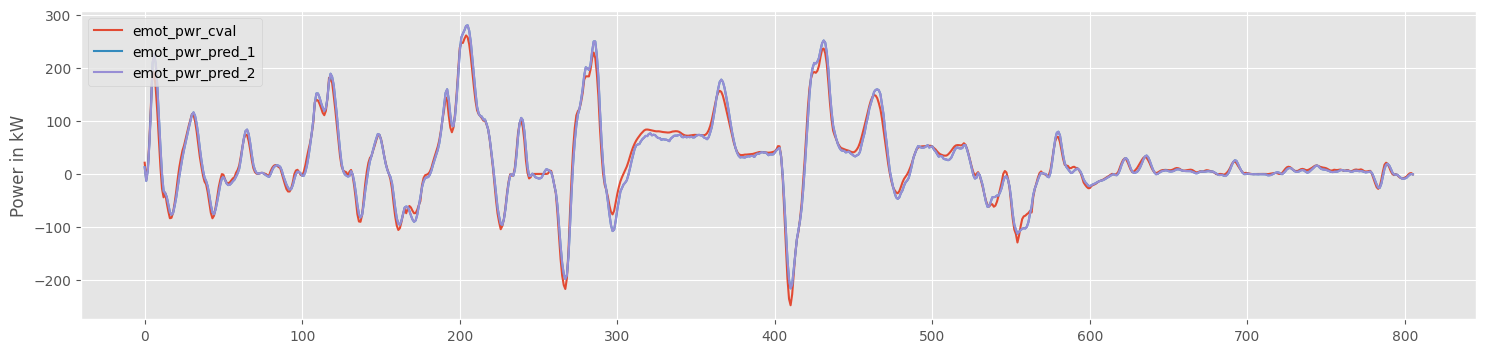

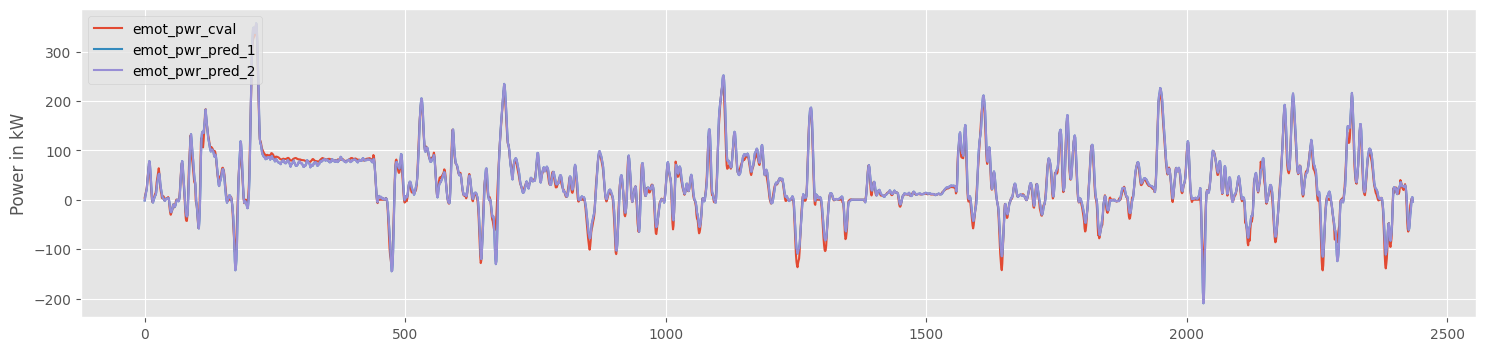

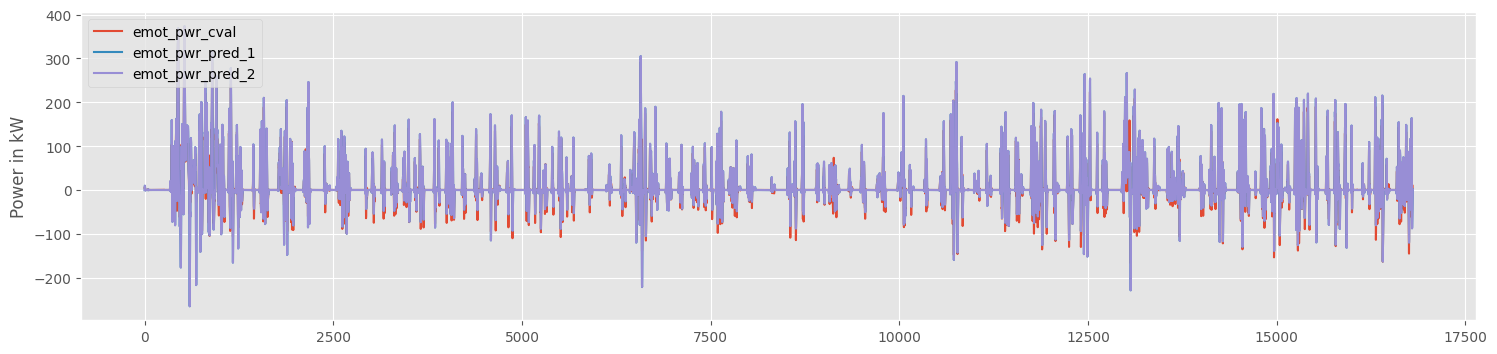

In [55]:
for n, f in enumerate(samples):
    print(n)

    file_code = f.strip(".parquet")
    print(file_code)

    with open(Path(pickle_folder, f'{file_code}.pickle'), 'rb') as handle:
        T,C,V_prm = pickle.load(handle) 

    df = pd.read_parquet(input_folder / f, engine='pyarrow')
    if "emot_pwr_cval" in df.columns:
        emot_pwr_true = df["emot_pwr_cval"].to_numpy()
        en = df["hv_batmomavldischrgen_cval_1"].to_numpy()
        soc = df["hv_bat_soc_cval_bms1"].to_numpy()
        dist = df["hirestotalvehdist_cval_icuc"].to_numpy()
        speed = (df["vehspd_cval_cpc"]/3.6).to_numpy()
        accel = np.diff(speed, prepend=speed[0])
        alt = df["altitude_cval_ippc"].to_numpy()
        road_grad = df["roadgrad_cval_pt"].to_numpy()
        amb_temp = df["airtempoutsd_cval_cpc"].to_numpy()
        vehweight = (df['vehweight_cval_pt']*1000).to_numpy()

    bat_pwr = df["hv_batpwr_cval_bms1"].to_numpy()
    soc_0 = soc[0]; en_0 = en[0]
    
    emot_pwr_pred_1 = estimate_mot_pwr(T.speed, 
                        T.accel, 
                        T.alt, 
                        T.road_grad, 
                        T.amb_temp, 
                        T.vehweight, 
                        V_prm["c_w_a"], 
                        V_prm["tire_roll_res_coeff"], 
                        rot_inertia = 0, 
                        eta_mech = 0.97,
                        eta_mot = 0.88
                        )

    emot_pwr_pred_2 = estimate_mot_pwr(speed, accel, alt, road_grad, amb_temp, vehweight, 
                    V_prm["c_w_a"], 
                    V_prm["tire_roll_res_coeff"], 
                    rot_inertia = 0, 
                    eta_mech = 0.97,
                    eta_mot = 0.88
                    )

    fig , axs = plt.subplots(1, sharex=True,figsize=(18, 4))
    if f == samples[0]: plt.suptitle('Simulated and Measured Power of E-Motors', fontsize='16')
    axs.set_ylabel('Power in kW', fontsize='12')
    axs.plot(savgol_filter(emot_pwr_true, 10, 3), label="emot_pwr_cval")
    axs.plot(savgol_filter(emot_pwr_pred_1, 10, 3), label="emot_pwr_pred_1")
    axs.plot(savgol_filter(emot_pwr_pred_2, 10, 3), label="emot_pwr_pred_2")
    #axs.plot(df.emot_pwr_cval - P_mot, label="diff")
    axs.legend(loc="upper left")
    #axs.set_xlim([24000,25000])


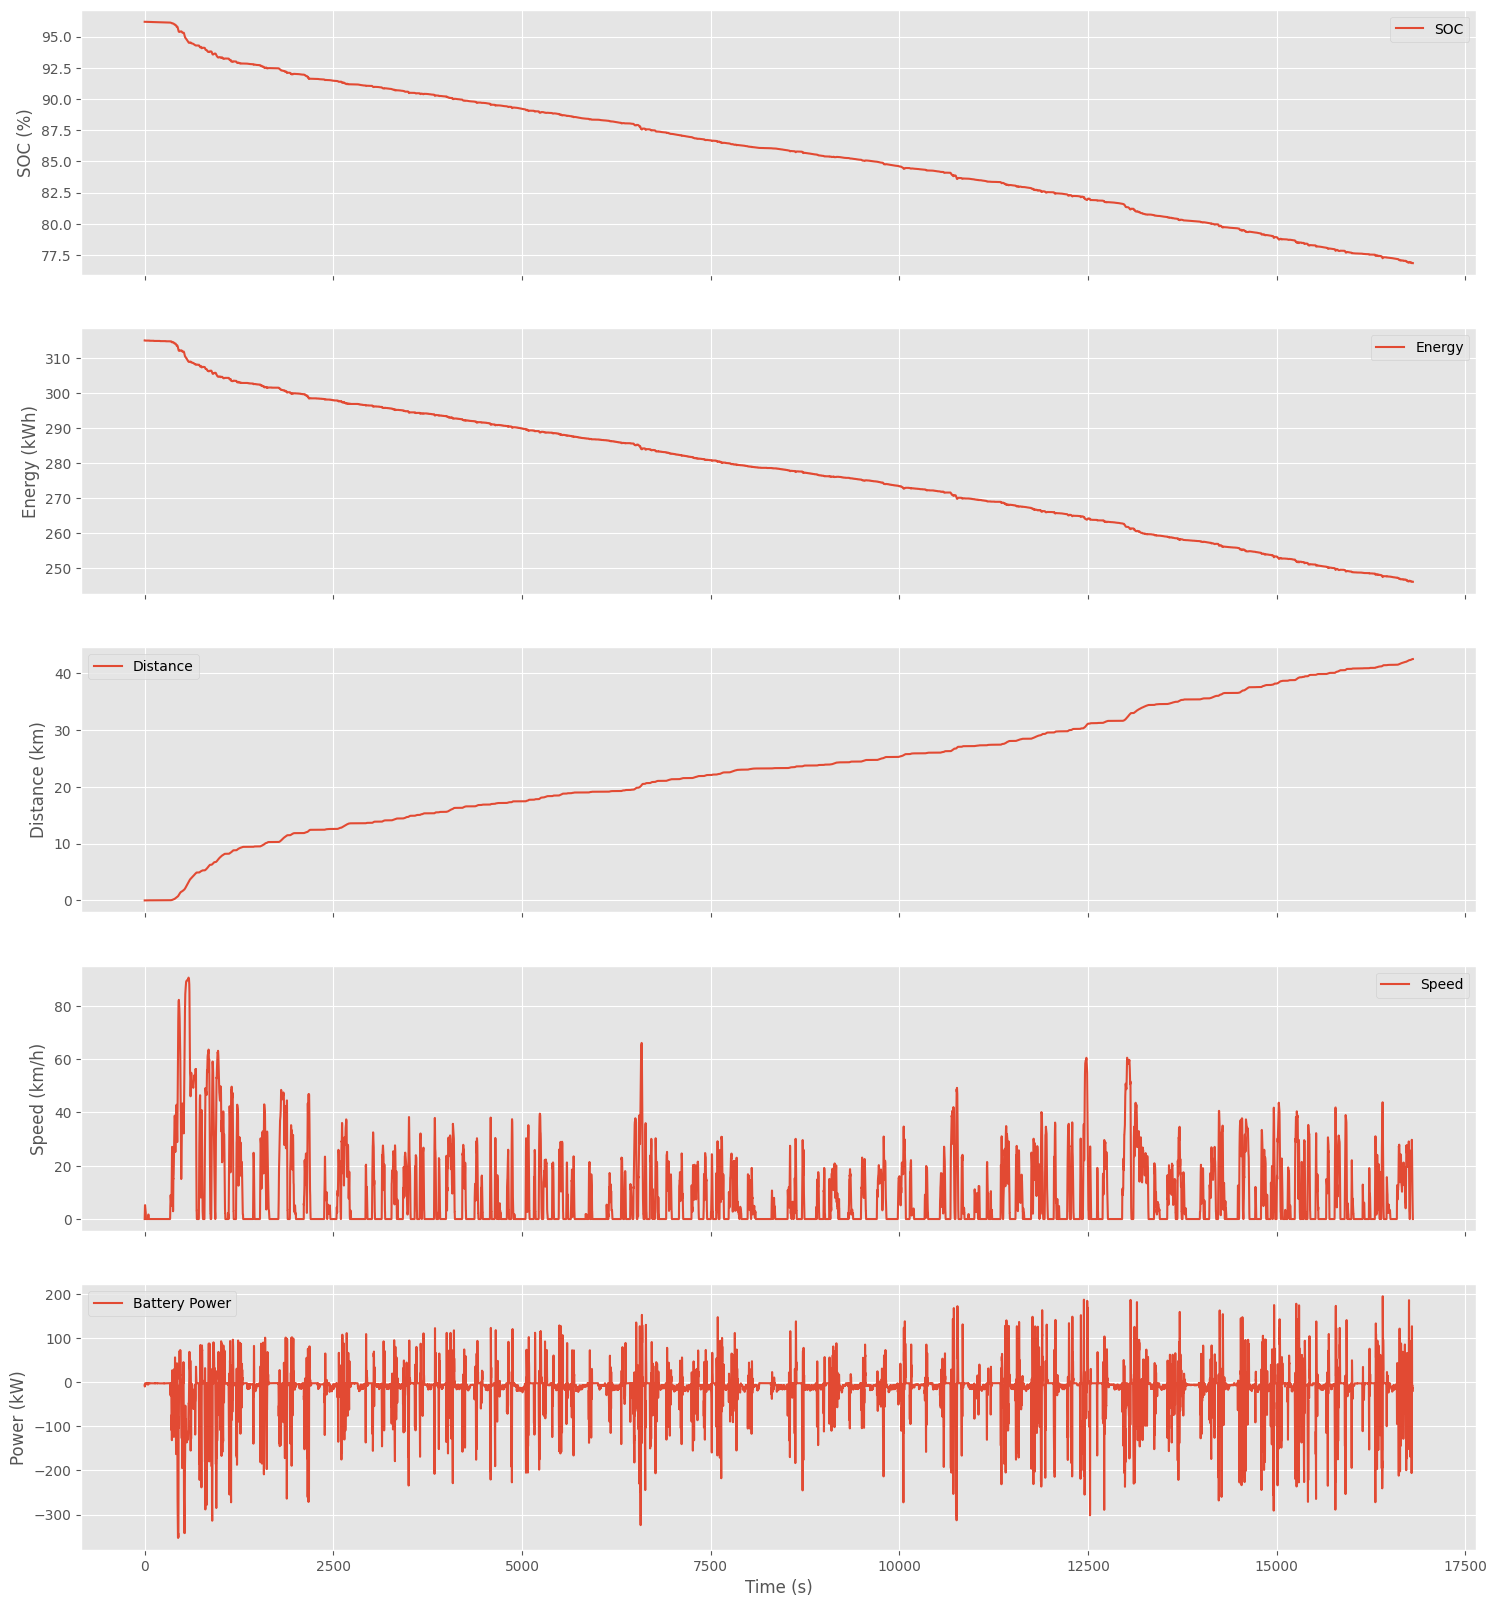

In [56]:
df = pd.read_parquet(input_folder / f, engine='pyarrow')

time = df.index.to_numpy()
soc = df["hv_bat_soc_cval_bms1"].to_numpy()
en = df["hv_batmomavldischrgen_cval_1"].to_numpy()
dist = df["hirestotalvehdist_cval_icuc"].to_numpy()
speed = df["vehspd_cval_cpc"].to_numpy()
bat_pwr = df["hv_batpwr_cval_bms1"].to_numpy()
hv_pwr = df["hv_pwr_cval_dcl1"].to_numpy()
soc_0 = soc[0]; en_0 = en[0]

fig, axs = plt.subplots(5, 1, figsize=(18, 20), sharex=True)
#fig.suptitle('Battery SOC, Energy, Distance, Speed, and Power', fontsize=16)

axs[0].plot(soc, label='SOC')
axs[0].set_ylabel('SOC (%)')
axs[0].legend()

axs[1].plot(en, label='Energy')
axs[1].set_ylabel('Energy (kWh)')
axs[1].legend()

axs[2].plot(dist, label='Distance')
axs[2].set_ylabel('Distance (km)')
axs[2].legend()

axs[3].plot(speed, label='Speed')
axs[3].set_ylabel('Speed (km/h)')
axs[3].legend()

axs[4].plot(bat_pwr, label='Battery Power')
#axs[4].plot(hv_pwr, label='HV Power', linestyle='--')
axs[4].set_ylabel('Power (kW)')
axs[4].set_xlabel('Time (s)')
axs[4].legend()

plt.show()

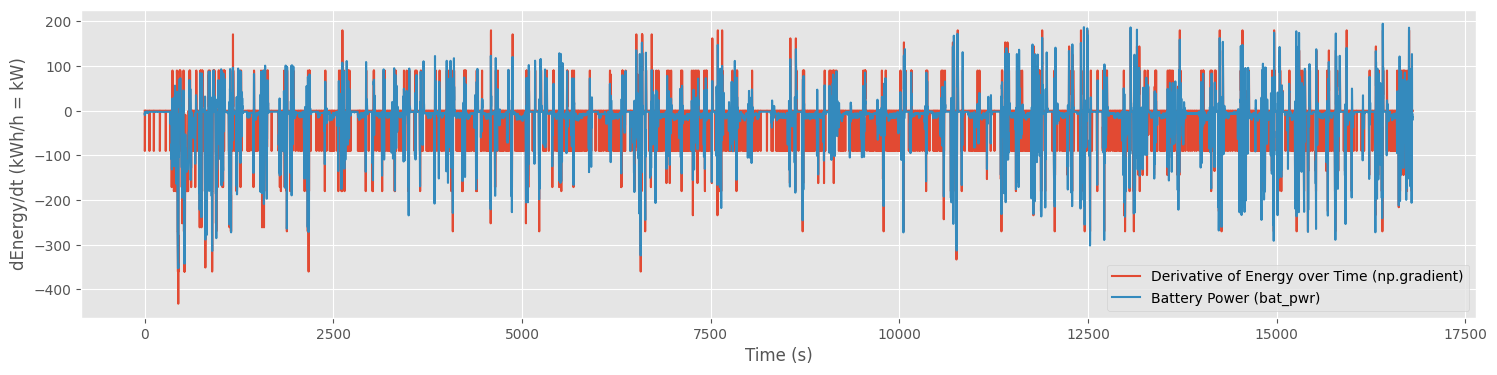

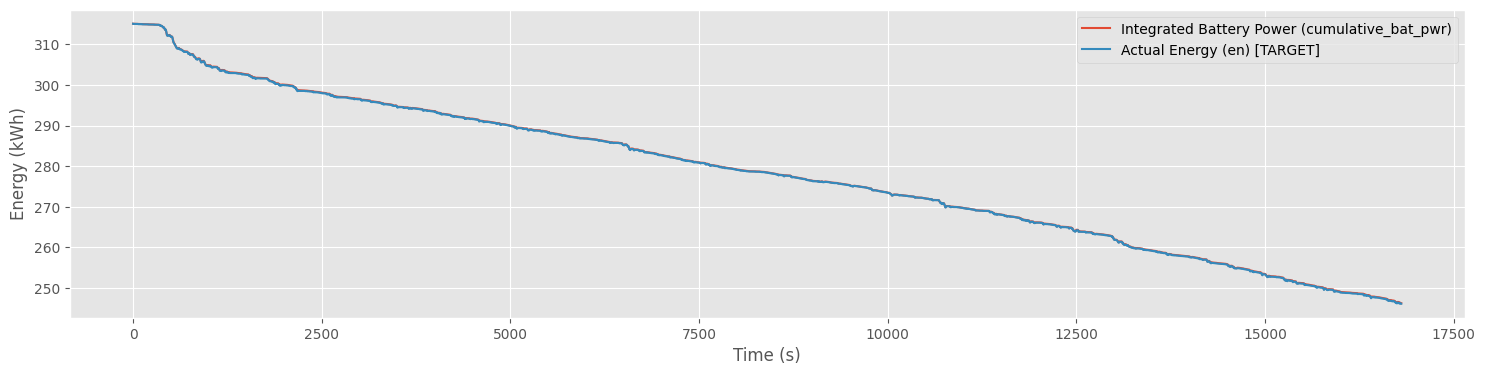

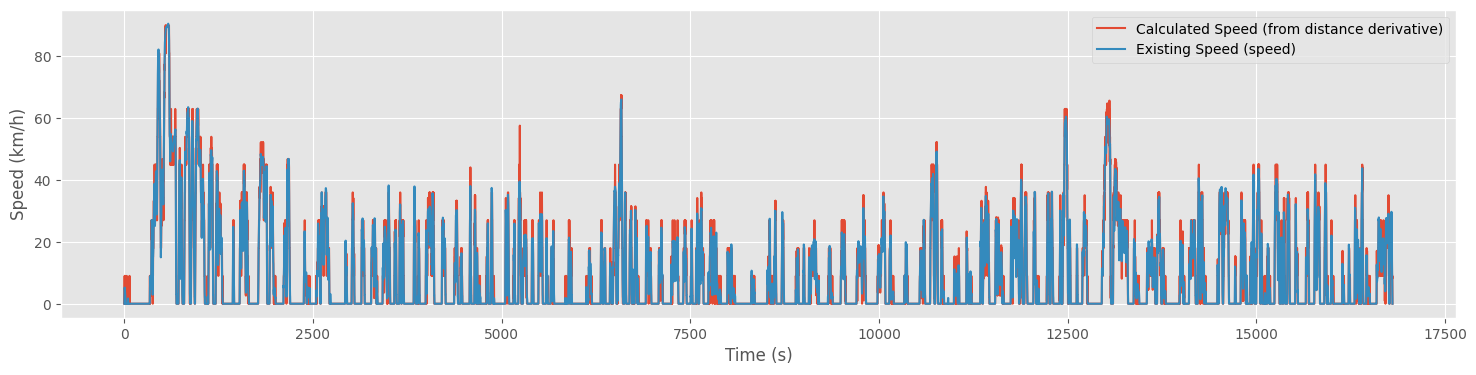

In [57]:

# Calculate derivative using np.gradient
en_derivative = np.gradient(en.flatten(), time) * 3600

# Calculate derivative using np.diff
en_diff = np.diff(en.flatten()) * 3600
en_diff = np.insert(en_diff, 0, 0)  # Insert 0 at the beginning to match the length

# Plot both derivatives and bat_pwr for comparison
plt.figure(figsize=(18, 4))
plt.plot(time, en_derivative, label='Derivative of Energy over Time (np.gradient)')
plt.plot(time, bat_pwr, label='Battery Power (bat_pwr)')
plt.xlabel('Time (s)')
plt.ylabel('dEnergy/dt (kWh/h = kW)')
plt.legend()
plt.show()

# Integrate bat_pwr to get cumulative energy and add en_0 to eliminate the offset
cumulative_bat_pwr = np.cumsum(bat_pwr) * (time[1] - time[0]) / 3600 + en_0  # Convert to kWh and add en_0

# Plot the integrated battery power and the actual energy
plt.figure(figsize=(18, 4))
plt.plot(time, cumulative_bat_pwr, label='Integrated Battery Power (cumulative_bat_pwr)')
plt.plot(time, en, label='Actual Energy (en) [TARGET]')
plt.xlabel('Time (s)')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()



# Calculate the speed as the derivative of the distance
calculated_speed = np.gradient(dist, time) * 3600  # Convert to km/h

# Plot the calculated speed and the existing speed for comparison
plt.figure(figsize=(18, 4))
plt.plot(time, calculated_speed, label='Calculated Speed (from distance derivative)')
plt.plot(time, speed, label='Existing Speed (speed)')
plt.xlabel('Time (s)')
plt.ylabel('Speed (km/h)')
plt.legend()
plt.show()

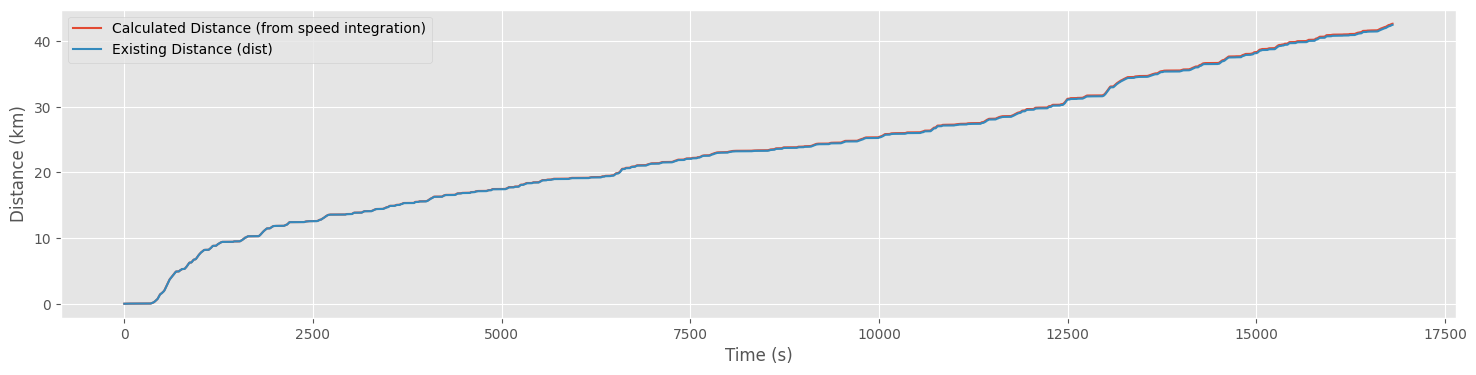

In [58]:
calculated_distance = np.cumsum(speed)  / 3600  # Convert to km

# Plot the calculated distance and the existing distance for comparison
plt.figure(figsize=(18, 4))
plt.plot(time, calculated_distance, label='Calculated Distance (from speed integration)')
plt.plot(time, dist, label='Existing Distance (dist)')
plt.xlabel('Time (s)')
plt.ylabel('Distance (km)')
plt.legend()
plt.show()

In [59]:
print(f"{'-'*60}")
en_max = en_0 / (soc_0/100)
print(f"Start Energy: {en_0:.2f} kWh")
print(f"Start SOC: {soc_0:.2f} %")
print(f"End SOC: {soc[-1]:.2f} %")
print(f"Max Energy: {en_max:.2f} kWh")
print(f"{'-'*60}")

delta_en = (en[-1] - en[0]) / (dist[-1]/100)
delta_soc = (soc[-1] - soc[0]) / (dist[-1]/100)
print(f"Consumption during Trip:{delta_en:.2f} kWh / 100km, \n\t\t\t{delta_soc:.2f} %SoC / 100km")
print(f"{'-'*60}")

mean_consumption = (bat_pwr.mean()/speed.mean())*100 # kWh per km
print(f"Mean Consumption: {mean_consumption:.2f} kWh / 100km")

------------------------------------------------------------
Start Energy: 315.10 kWh
Start SOC: 96.19 %
End SOC: 76.86 %
Max Energy: 327.58 kWh
------------------------------------------------------------
Consumption during Trip:-162.29 kWh / 100km, 
			-45.51 %SoC / 100km
------------------------------------------------------------
Mean Consumption: -161.33 kWh / 100km


In [60]:
soc[-1] - soc[0]

-19.333437500000002

In [61]:
C_nom = (en[-1] - en[0])/((soc[-1] - soc[0])/100)
E_Bat = np.cumsum(bat_pwr)/3600

In [62]:
en_0
soc_0
C_nom = 336

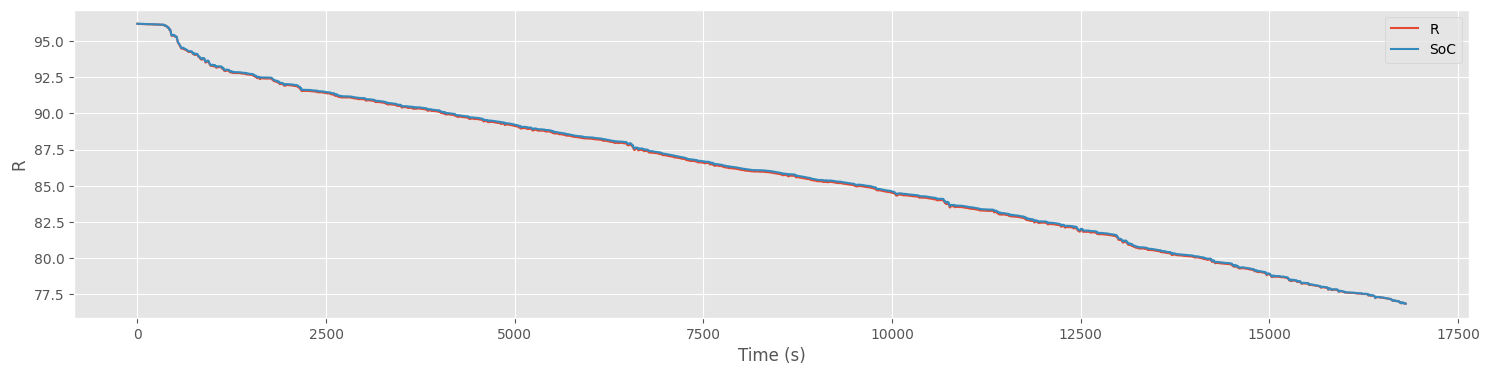

In [63]:
delta_soc = soc[-1] - soc[0]
delta_en = en[-1] - en[0]
C_nom = (delta_en/delta_soc) * 100

R = soc_0 - 100*(en_0 - en) / C_nom

plt.figure(figsize=(18, 4))
plt.plot(time, R, label='R')
plt.plot(time, soc, label='SoC')
plt.xlabel('Time (s)')
plt.ylabel('R')
plt.legend()
plt.show()

NameError: name 'emot_pwr_pred' is not defined

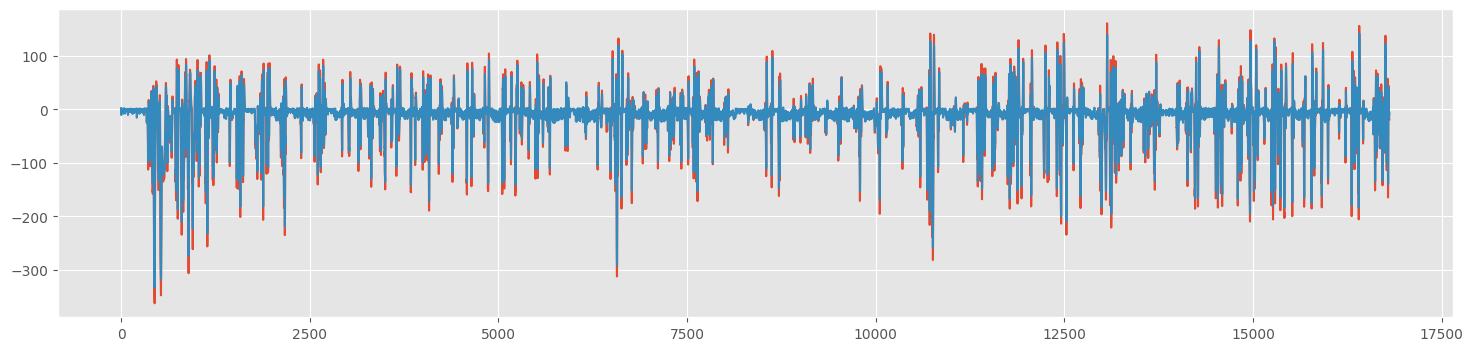

In [64]:
soc_gradient = np.gradient(soc.flatten(), time)
en_gradient = np.gradient(en.flatten(), time)

plt.figure(figsize=(18, 4))
plt.plot(time, savgol_filter(bat_pwr,10,3), label='Battery Power (bat_pwr)')
plt.plot(time, savgol_filter(soc_gradient,10,3) * 3.27 * 3600, label='Gradient of SOC')
plt.plot(time, savgol_filter(-emot_pwr_pred,10,3), label='Predicted Motor Power (emot_pwr_pred)')

plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(bat_pwr[:1001], en_gradient[:1001] * 3.49))
print(f"RMSE between bat_pwr and en_gradient: {rmse}")

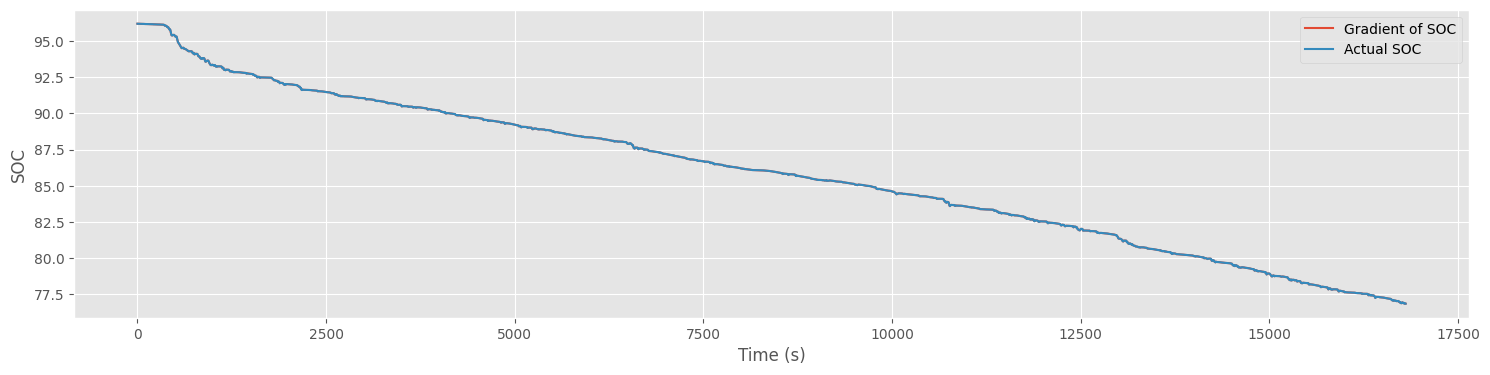

In [67]:
plt.figure(figsize=(18, 4))
plt.plot(time, soc_0 + np.cumsum(soc_gradient), label='Gradient of SOC')
plt.plot(time, soc, label='Actual SOC')
plt.xlabel('Time (s)')
plt.ylabel('SOC')
plt.legend()
plt.show()

In [ ]:
hv_batt_installed_capacity = V_prm['hv_batt_installed_capacity']
hv_batt_total_capacity = V_prm['hv_batt_total_capacity']
print(f"hv_batt_installed_capacity: {hv_batt_installed_capacity}")
print(f"hv_batt_total_capacity: {hv_batt_total_capacity}")

In [ ]:
cumulative_bat_pwr = np.cumsum(bat_pwr) / 3600 # Convert to kWh

plt.figure(figsize=(18, 4))
plt.plot(time, cumulative_bat_pwr, label='Cumulative Battery Power (kWh)')
plt.plot(time, en - en_0, label='(SOC) [TARGET]')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Battery Power (kWh)')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(bat_pwr / np.cumsum(dist), label='Cumulative Battery Power (kWh)')
np.cumsum(bat_pwr) / np.cumsum(bat_pwr)[-1]

In [ ]:
bat_pwr_div_speed = np.nan_to_num(bat_pwr/speed, nan=0.0, posinf=0.0, neginf=0.0)
bat_pwr_div_speed

In [ ]:
np.nancumsum(bat_pwr/speed)

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(bat_pwr/(speed), label='Cumulative Battery Power (kWh)')
#plt.plot(dist, label='Cumulative Battery Power (kWh)')

In [ ]:
np.cumsum(dist[-1] - dist)

In [ ]:
cumulative_bat_pwr = (np.cumsum(bat_pwr) / 3600) / (dist[-1] - dist) # Convert to kWh

plt.figure(figsize=(18, 4))
plt.plot(cumulative_bat_pwr[:3600], label='Cumulative Battery Power (kWh)')
#plt.plot(time, en - en_0, label='(SOC) [TARGET]')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Battery Power (kWh)')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(time, en/en_max*100, label='Energy (en) [kWh]')
plt.plot(time, soc, label='State of Charge (soc) [%]')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
# Integrate bat_pwr to get cumulative energy and add en_0 to eliminate the offset
cumulative_bat_pwr = np.cumsum(bat_pwr) / 3600  # Convert to kWh and add en_0

# Plot the integrated battery power and the actual energy
plt.figure(figsize=(18, 4))
en_max = en_0 / (soc_0/100)
plt.plot(time, cumulative_bat_pwr*100/en_max + soc_0, label='Integrated Battery Power (cumulative_bat_pwr)')
plt.plot(time, soc, label='(SOC) [TARGET]')
plt.xlabel('Time (s)')
plt.ylabel('Energy (% SoC)')
plt.legend()
plt.show()

In [ ]:
# Calculate the derivative of energy with respect to driven distance
epsilon = 1e-6  # Small value to avoid division by zero
calculated_distance = np.cumsum(speed)  / 3600
dist_with_epsilon = calculated_distance + epsilon
en_derivative_dist = np.gradient(en.flatten(), calculated_distance) * 100

# Replace outliers with NaNs
en_derivative_dist[en_derivative_dist < -4000] = np.nan

# Replace NaNs with zero or another specified value
en_derivative_dist = np.nan_to_num(en_derivative_dist, nan=0.0, posinf=0.0, neginf=0.0)

# Plot the momentaneous energy consumption
plt.figure(figsize=(18, 4))
plt.plot(time, en_derivative_dist, label='Momentaneous Energy Consumption (en_derivative_dist)')
plt.xlabel('Time (s)')
plt.ylabel('dEnergy/dDistance (kWh / 100 km)')
plt.legend()
plt.show()


In [ ]:
#kWh/h 

a = (np.cumsum(bat_pwr) / 3600) / (np.cumsum(speed)/3600) * 100
#a = np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0)
plt.figure(figsize=(18, 4))
plt.plot( a[100:], label='Energy Consumption (kWh/100km)')
plt.xlabel('Time (s)')
plt.ylabel('Energy Consumption (kWh/100km)')
plt.legend()
plt.show()

In [ ]:
a.mean()

In [ ]:
en_derivative_dist.mean()*(dist[-1]/100)

In [ ]:
delta_en = (en[-1] - en[0]) / (dist[-1]/100)
delta_soc = (soc[-1] - soc[0]) / (dist[-1]/100)
print(f"{delta_en:.2f} kWh/100km, {delta_soc:.2f} %/100km")

In [ ]:
# Calculate the difference in energy and distance
delta_en = np.diff(en)
delta_dist = np.diff(dist)

# Avoid division by zero by adding a small epsilon to delta_dist
epsilon = 1e-8
delta_dist_with_epsilon = delta_dist + epsilon

# Calculate the momentaneous energy consumption in kWh/km
momentaneous_energy_consumption = delta_en / delta_dist_with_epsilon

# Insert a NaN at the beginning to match the length of the original arrays
momentaneous_energy_consumption = np.insert(momentaneous_energy_consumption, 0, np.nan)

# Plot the momentaneous energy consumption
plt.figure(figsize=(18, 4))
plt.plot(time, momentaneous_energy_consumption, label='Momentaneous Energy Consumption (kWh/km)')
plt.xlabel('Time (s)')
plt.ylabel('Energy Consumption (kWh/km)')
plt.legend()
plt.show()

In [ ]:
speed
en

In [ ]:
calculated_distance = np.cumsum(speed)  / 3600  # [km]
en # [kWh]
momentary_consumption = en / (calculated_distance + 1e-8)  # kWh per km
plt.figure(figsize=(18, 4))
plt.plot(time[109:], momentary_consumption[110:], label='Momentary Consumption (kWh/km)')
plt.xlabel('Time (s)')
plt.ylabel('Consumption (kWh/km)')
plt.legend()
plt.show()

In [ ]:
bat_pwr # [kW]
speed # [km/h]
momentary_consumption_rate = bat_pwr / (speed + 1e-8)  # kWh per km


plt.figure(figsize=(18, 4))
plt.plot(time_trimmed, momentary_consumption_rate[1:], label='Momentary Consumption Rate (kWh/km)')
plt.xlabel('Time (s)')
plt.ylabel('Consumption Rate (kWh/km)')
plt.legend()
plt.show()

In [ ]:
C_dict = {}
for n, f in enumerate(all_files):
    print(n)

    file_code = f.strip(".parquet")
    v_id = file_code.split("_")[0].strip("V")

    if v_id not in C_dict:
        C_dict[v_id] = []

    df = pd.read_parquet(input_folder / f, engine='pyarrow', columns = ['hv_bat_soc_cval_bms1', 'hv_batmomavldischrgen_cval_1'])

    if len(df) > 3600:
        soc = df["hv_bat_soc_cval_bms1"].to_numpy()
        en = df["hv_batmomavldischrgen_cval_1"].to_numpy()


        delta_soc = soc[-1] - soc[0]
        delta_en = en[-1] - en[0]
        C_nom = (delta_en/delta_soc) * 100
        C_dict[v_id].append(C_nom)
        
        

        print(f"{'-'*60}")
        print(file_code)
        print(C_nom)


In [ ]:
C_dict
for key, value_list in C_dict.items():
    mean_value = np.mean(value_list)
    print(f"{key}: {mean_value}, {len(value_list)}")